In [8]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Tratamiendo_imgs/Proyecto/')
image_path = '/content/drive/MyDrive/Colab Notebooks/Tratamiendo_imgs/Proyecto/test_images/img19_retrato.jpeg'

ruta_modelo = "/content/deeplab_model/deeplabv3_mnv2_pascal_train_aug/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb"

In [2]:
import os
import tarfile
import cv2

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests


import tensorflow as tf

In [3]:
# URL del modelo preentrenado y nombre del archivo descargado
url = "https://github.com/qixuxiang/deeplabv3plus/raw/master/model/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz"
nombre_archivo = "deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz"

# Ruta donde se extraerá el modelo
ruta_modelo = "./deeplab_model/deeplabv3_mnv2_pascal_train_aug/"

# Descargar el archivo
respuesta = requests.get(url)
with open(nombre_archivo, "wb") as archivo:
    archivo.write(respuesta.content)

# Extraer el modelo
with tarfile.open(nombre_archivo, "r:gz") as tar:
    tar.extractall(ruta_modelo)

In [4]:
class DeepLabModel:
    def __init__(self, model_path):
        # Cargar el grafo desde el archivo .pb
        self.graph = tf.Graph()
        with self.graph.as_default():
            graph_def = tf.compat.v1.GraphDef()
            with tf.io.gfile.GFile(model_path, 'rb') as f:
                graph_def.ParseFromString(f.read())
                tf.import_graph_def(graph_def, name='')

        # Obtener el tensor de entrada y salida del grafo
        self.input_tensor = self.graph.get_tensor_by_name('ImageTensor:0')
        self.output_tensor = self.graph.get_tensor_by_name('SemanticPredictions:0')

    def run(self, image_array):
        # Crear una sesión TensorFlow
        with tf.compat.v1.Session(graph=self.graph) as sess:
            # Ejecutar la predicción
            predicted_map = sess.run(self.output_tensor, feed_dict={self.input_tensor: [image_array]})
        return predicted_map>0.1

In [5]:
# Función para redimensionar la imagen
def resize_image(image, target_size):
    return image.resize(target_size, Image.ANTIALIAS)

# Función para redimensionar la máscara
def resize_mask(mask, target_size):
    return mask.resize(target_size, Image.NEAREST)

In [9]:


# Crear una instancia del modelo DeepLab
modelo_deeplab = DeepLabModel(ruta_modelo)

# Cargar la imagen
imagen = Image.open(image_path)

# Redimensionar la imagen al tamaño esperado por el modelo
target_size = (513, 513)  # Tamaño esperado por el modelo DeepLab
imagen_resized = resize_image(imagen, target_size)

# Convertir la imagen redimensionada a un array numpy
imagen_array = np.array(imagen_resized)

# Realizar la predicción con el modelo cargado
resultado_prediccion = modelo_deeplab.run(imagen_array)
img_result = resultado_prediccion.squeeze()
mascara_prediccion = Image.fromarray(img_result.astype(np.uint8))
mascara_prediccion_resized = resize_mask(mascara_prediccion, imagen.size)

# El resultado de la predicción es un tensor que representa la segmentación semántica de la imagen

<ipython-input-5-3c94f4a07f14>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(target_size, Image.ANTIALIAS)


In [10]:
print(resultado_prediccion.shape)
print(imagen_array.shape)
img_result = resultado_prediccion.squeeze()
print(img_result.shape)


(1, 513, 513)
(513, 513, 3)
(513, 513)


In [11]:
print(np.max(img_result))

True


In [31]:
f = cv2.imread(image_path, cv2.IMREAD_COLOR)
f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f = f.astype(np.float32)
f_dim = (np.array(f.shape[0:2])//10)*10
dim = tuple(f_dim.flatten())


<class 'tuple'>
(180, 240)


(240, 180, 3)
1.0


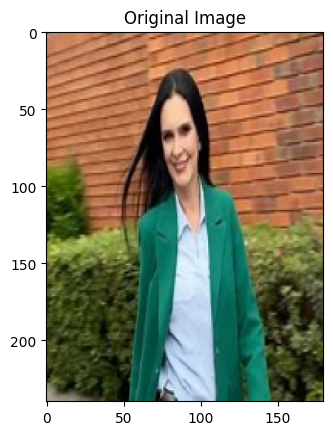

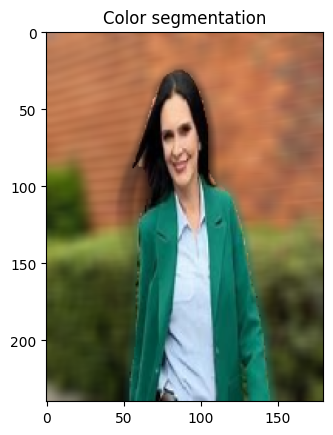

(<matplotlib.image.AxesImage at 0x7aac22c75cf0>,
 Text(0.5, 1.0, 'Color segmentation'),
 None)

In [32]:
f = cv2.imread(image_path, cv2.IMREAD_COLOR)
f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f = f.astype(np.float32)
f_dim = (np.array(f.shape[0:2])//10)*10

dim = tuple(f_dim.flatten())
# resize image
f = cv2.resize(f, dim, interpolation = cv2.INTER_AREA)

print(f.shape)
#g = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)/255
#g = cv2.GaussianBlur(f,(10,10),cv2.BORDER_DEFAULT)
g = cv2.blur(f,(1000,1000))
mascara_prediccion_resized = np.array(mascara_prediccion_resized)
mascara_prediccion_resized = cv2.resize(mascara_prediccion_resized, dim, interpolation = cv2.INTER_AREA)
mask = np.dstack((mascara_prediccion_resized, mascara_prediccion_resized, mascara_prediccion_resized))
#g = np.dstack((g,g,g))
h = f/255.0
c = np.clip(g*(1-mask),0,1).astype(np.float32)
c = c*cv2.blur(h,(10,10)) + h*mask
print(c.max())
#dst = cv2.GaussianBlur(h*mask,(10,10),cv2.BORDER_DEFAULT)
#c = dst + g*(1-mask)
#dst = cv2.GaussianBlur(h*mask,(5,5),cv2.BORDER_DEFAULT)

plt.imshow(h), plt.title('Original Image'), plt.show()
plt.imshow(c), plt.title('Color segmentation'), plt.show()